In [ ]:

import os
import sys
from tempfile import NamedTemporaryFile
from urllib.request import urlopen
from urllib.parse import unquote, urlparse
from urllib.error import HTTPError
from zipfile import ZipFile
import tarfile
import shutil

CHUNK_SIZE = 40960
DATA_SOURCE_MAPPING = 'breast-histopathology-images:https%3A%2F%2Fstorage.googleapis.com%2Fkaggle-data-sets%2F7415%2F10564%2Fbundle%2Farchive.zip%3FX-Goog-Algorithm%3DGOOG4-RSA-SHA256%26X-Goog-Credential%3Dgcp-kaggle-com%2540kaggle-161607.iam.gserviceaccount.com%252F20240428%252Fauto%252Fstorage%252Fgoog4_request%26X-Goog-Date%3D20240428T094149Z%26X-Goog-Expires%3D259200%26X-Goog-SignedHeaders%3Dhost%26X-Goog-Signature%3D1279ec694c939fe897f456f3385f658ebea5f08ed05f660c03f51928c723d7d499bc38f6e60bfad66fc29cb851615efb9b06e242fe180086c46b6aea7fd3c6481533b95ebdaee90edb5f0ba6ceda74aa46cc897f6033b86c6b64572059432f2bf3a44e4c9862aa03f0fd245cececcfb53d3eb4c0ed1ec8e00466d6e6018ae3b4f93d52cb3ed889efd0f56dff77f24a4a041e9eca4d6f663c36f92ce312ce4ff22565ec3649fe0082dc16fba3ae6577db8ec8ab87f77dfca74ddc6b2a242ea24f7f5570ddea33b03dafcd8bf75782a8e135a4d46f4391e354dd92d08918676483365de15ddc10e684b499a031e482793363a3a674374dc83a8e2bb4bf731c3ddb'

KAGGLE_INPUT_PATH='/kaggle/input'
KAGGLE_WORKING_PATH='/kaggle/working'
KAGGLE_SYMLINK='kaggle'

!umount /kaggle/input/ 2> /dev/null
shutil.rmtree('/kaggle/input', ignore_errors=True)
os.makedirs(KAGGLE_INPUT_PATH, 0o777, exist_ok=True)
os.makedirs(KAGGLE_WORKING_PATH, 0o777, exist_ok=True)

try:
  os.symlink(KAGGLE_INPUT_PATH, os.path.join("..", 'input'), target_is_directory=True)
except FileExistsError:
  pass
try:
  os.symlink(KAGGLE_WORKING_PATH, os.path.join("..", 'working'), target_is_directory=True)
except FileExistsError:
  pass

for data_source_mapping in DATA_SOURCE_MAPPING.split(','):
    directory, download_url_encoded = data_source_mapping.split(':')
    download_url = unquote(download_url_encoded)
    filename = urlparse(download_url).path
    destination_path = os.path.join(KAGGLE_INPUT_PATH, directory)
    try:
        with urlopen(download_url) as fileres, NamedTemporaryFile() as tfile:
            total_length = fileres.headers['content-length']
            print(f'Downloading {directory}, {total_length} bytes compressed')
            dl = 0
            data = fileres.read(CHUNK_SIZE)
            while len(data) > 0:
                dl += len(data)
                tfile.write(data)
                done = int(50 * dl / int(total_length))
                sys.stdout.write(f"\r[{'=' * done}{' ' * (50-done)}] {dl} bytes downloaded")
                sys.stdout.flush()
                data = fileres.read(CHUNK_SIZE)
            if filename.endswith('.zip'):
              with ZipFile(tfile) as zfile:
                zfile.extractall(destination_path)
            else:
              with tarfile.open(tfile.name) as tarfile:
                tarfile.extractall(destination_path)
            print(f'\nDownloaded and uncompressed: {directory}')
    except HTTPError as e:
        print(f'Failed to load (likely expired) {download_url} to path {destination_path}')
        continue
    except OSError as e:
        print(f'Failed to load {download_url} to path {destination_path}')
        continue

print('Data source import complete.')

[==================================================] 3326820824 bytes downloaded
Downloaded and uncompressed: breast-histopathology-images
Data source import complete.


# Importing Necessary libraries

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
import cv2
import glob
import random
from os import listdir
from sklearn.metrics import classification_report
import tensorflow as tf
import keras.utils as image


# Loading Dataset

In [ ]:
breast_img = glob.glob('/kaggle/input/breast-histopathology-images/IDC_regular_ps50_idx5/**/*.png', recursive = True)

for imgname in breast_img[:3]:
    print(imgname)

/kaggle/input/breast-histopathology-images/IDC_regular_ps50_idx5/8950/0/8950_idx5_x1951_y1351_class0.png
/kaggle/input/breast-histopathology-images/IDC_regular_ps50_idx5/8950/0/8950_idx5_x1651_y1501_class0.png
/kaggle/input/breast-histopathology-images/IDC_regular_ps50_idx5/8950/0/8950_idx5_x2151_y1051_class0.png


# Visualizing Dataset

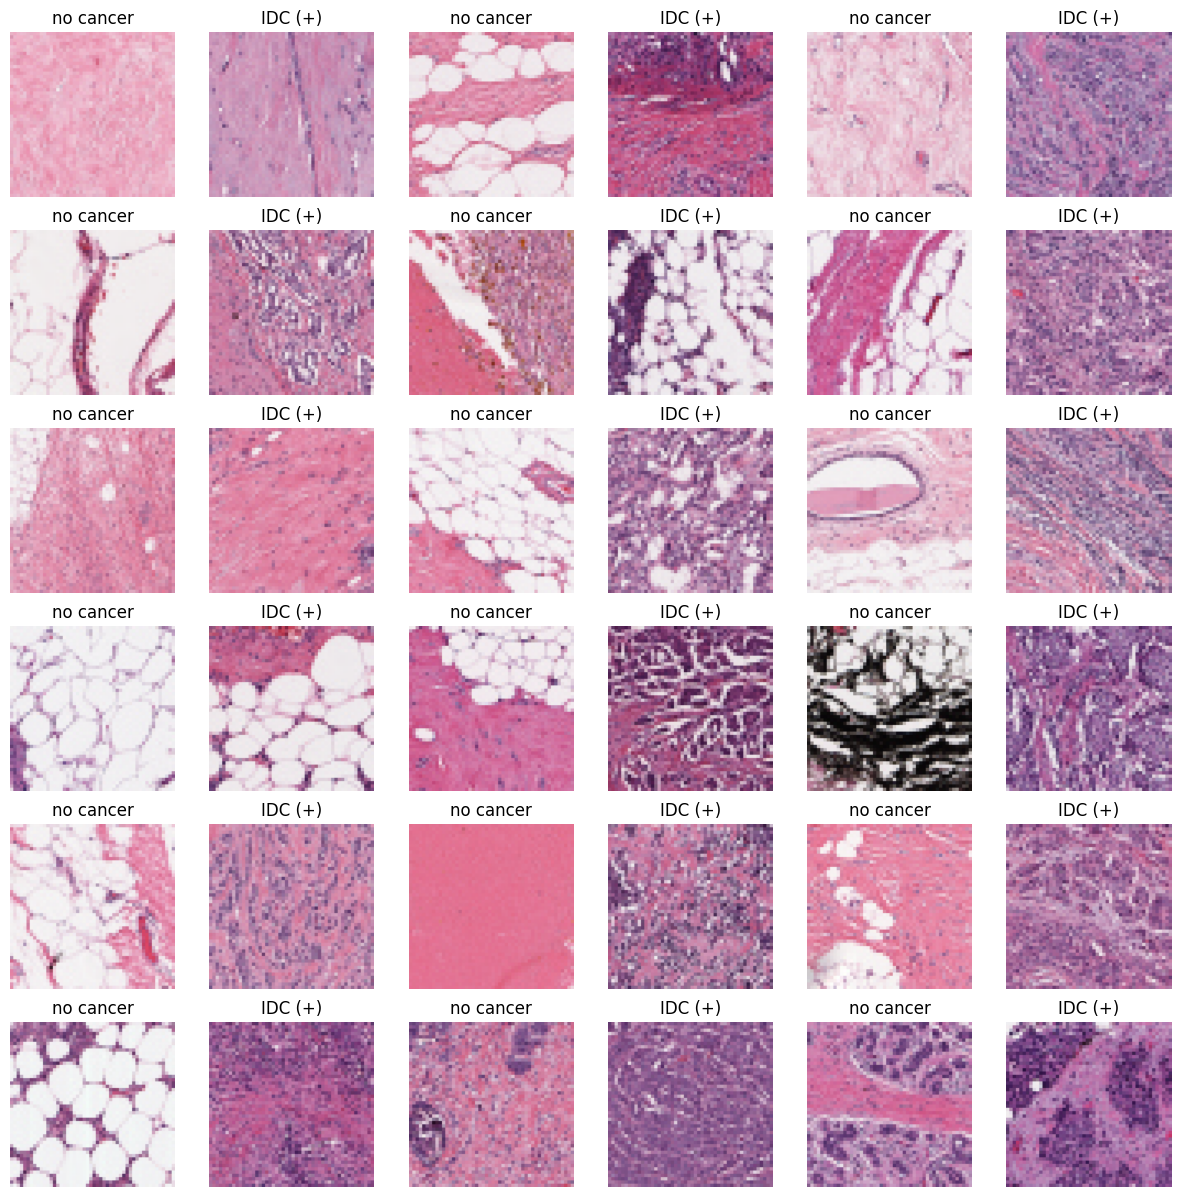

In [ ]:
N_IDC = []
P_IDC = []

for img in breast_img:
    if img[-5] == '0' :
        N_IDC.append(img)

    elif img[-5] == '1' :
        P_IDC.append(img)
plt.figure(figsize = (15, 15))

some_non = np.random.randint(0, len(N_IDC), 18)
some_can = np.random.randint(0, len(P_IDC), 18)

s = 0
for num in some_non:

        img = image.load_img((N_IDC[num]), target_size=(100, 100))
        img = image.img_to_array(img)

        plt.subplot(6, 6, 2*s+1)
        plt.axis('off')
        plt.title('no cancer')
        plt.imshow(img.astype('uint8'))
        s += 1
s = 1
for num in some_can:

        img = image.load_img((P_IDC[num]), target_size=(100, 100))
        img = image.img_to_array(img)

        plt.subplot(6, 6, 2*s)
        plt.axis('off')
        plt.title('IDC (+)')
        plt.imshow(img.astype('uint8'))
        s += 1


In [ ]:
NewN_IDC=N_IDC[:78786]
print(len(NewN_IDC))
print(len(P_IDC))

78786
78786


# Data Preprocessing

In [ ]:
non_img_arr = []
can_img_arr = []

for img in NewN_IDC:

    n_img = cv2.imread(img, cv2.IMREAD_COLOR)
    n_img_size = cv2.resize(n_img, (50, 50), interpolation = cv2.INTER_LINEAR)
    non_img_arr.append([n_img_size, 0])

for img in P_IDC:
    c_img = cv2.imread(img, cv2.IMREAD_COLOR)
    c_img_size = cv2.resize(c_img, (50, 50), interpolation = cv2.INTER_LINEAR)
    can_img_arr.append([c_img_size, 1])


In [ ]:
print(len(non_img_arr))
print(len(can_img_arr))
print(len(non_img_arr)+len(can_img_arr))

78786
78786
157572


In [ ]:
total = len(N_IDC) + len(P_IDC)
ppos = len(P_IDC)/total
desired = 40000
psamp = desired/total
print(total, ppos, desired, psamp)

non_img_arr = []
can_img_arr = []
non_y = []
can_y = []

# downsample to limit RAM usage
for i,img in enumerate(N_IDC):
    if (np.random.uniform() < psamp):
      n_img = cv2.imread(img, cv2.IMREAD_COLOR)
      n_img = cv2.resize(n_img, (50, 50), interpolation = cv2.INTER_LINEAR)
      non_img_arr.append(n_img)
      non_y.append(0)

for i,img in enumerate(P_IDC):
    if (np.random.uniform() < psamp):
      c_img = cv2.imread(img, cv2.IMREAD_COLOR)
      c_img = cv2.resize(c_img, (50, 50), interpolation = cv2.INTER_LINEAR)
      can_img_arr.append(c_img)
      can_y.append(1)

X = np.concatenate((non_img_arr, can_img_arr))
y = np.concatenate([non_y,can_y])


277524 0.28388896095472826 40000 0.14413167870166183


In [ ]:
def describeData(a,b):
    print('Total number of images: {}'.format(len(a)))
    print('Number of IDC(-) Images: {}'.format(np.sum(b==0)))
    print('Number of IDC(+) Images: {}'.format(np.sum(b==1)))
    print('Image shape (Width, Height, Channels): {}'.format(a[0].shape))
describeData(X,y)


Total number of images: 40197
Number of IDC(-) Images: 28787
Number of IDC(+) Images: 11410
Image shape (Width, Height, Channels): (50, 50, 3)


In [ ]:
from sklearn.model_selection import train_test_split
X_train, X_test, Y_train, Y_test = train_test_split(X, y, test_size=0.3)

from tensorflow.keras.utils import to_categorical
Y_train = to_categorical(Y_train, num_classes = 2)
Y_test = to_categorical(Y_test, num_classes = 2)

print("Training Data Shape:", X_train.shape)
print("Testing Data Shape:", X_test.shape)


Training Data Shape: (28137, 50, 50, 3)
Testing Data Shape: (12060, 50, 50, 3)


# Modeling

In [ ]:
from sklearn.metrics import classification_report
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Conv2D,MaxPooling2D, Flatten, Dropout, BatchNormalization
from tensorflow.keras.optimizers import SGD
from tensorflow.keras.optimizers import Adam, SGD
from keras.metrics import binary_crossentropy
from tensorflow.keras.callbacks import EarlyStopping
from sklearn.metrics import confusion_matrix
import itertools


In [ ]:
early_stop=EarlyStopping(monitor='val_loss',patience=5)
model = Sequential()
model.add(Conv2D(32, (3, 3), activation='relu', kernel_initializer='he_uniform', padding='same', input_shape=(50, 50, 3)))
model.add(BatchNormalization())
model.add(Conv2D(32, (3, 3), activation='relu', kernel_initializer='he_uniform', padding='same'))
model.add(MaxPooling2D((2, 2)))
model.add(BatchNormalization())
model.add(Dropout(0.3))
model.add(Conv2D(64, (3, 3), activation='relu', kernel_initializer='he_uniform', padding='same'))
model.add(BatchNormalization())
model.add(Conv2D(64, (3, 3), activation='relu', kernel_initializer='he_uniform', padding='same'))
model.add(BatchNormalization())
model.add(MaxPooling2D((2, 2)))
model.add(Dropout(0.3))
model.add(Conv2D(128, (3, 3), activation='relu', kernel_initializer='he_uniform', padding='same'))
model.add(Flatten())
model.add(Dense(128, activation='relu', kernel_initializer='he_uniform'))
model.add(BatchNormalization())
model.add(Dense(64, activation='relu', kernel_initializer='he_uniform'))
model.add(BatchNormalization())
model.add(Dense(64, activation='relu', kernel_initializer='he_uniform'))
model.add(Dropout(0.3))
model.add(Dense(24, activation='relu', kernel_initializer='he_uniform'))
model.add(Dense(2, activation='softmax'))

In [ ]:
model.compile(Adam(learning_rate=0.0001), loss='binary_crossentropy', metrics=['accuracy'])

In [ ]:
model.summary()


Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 50, 50, 32)        896       
                                                                 
 batch_normalization (Batch  (None, 50, 50, 32)        128       
 Normalization)                                                  
                                                                 
 conv2d_1 (Conv2D)           (None, 50, 50, 32)        9248      
                                                                 
 max_pooling2d (MaxPooling2  (None, 25, 25, 32)        0         
 D)                                                              
                                                                 
 batch_normalization_1 (Bat  (None, 25, 25, 32)        128       
 chNormalization)                                                
                                                        

In [ ]:
history = model.fit(X_train, Y_train, validation_data = (X_test, Y_test), epochs = 10, batch_size = 35)


Epoch 1/10
804/804 [==============================] - 503s 619ms/step - loss: 0.4509 - accuracy: 0.8129 - val_loss: 0.4055 - val_accuracy: 0.8126
Epoch 2/10
804/804 [==============================] - 519s 645ms/step - loss: 0.3867 - accuracy: 0.8345 - val_loss: 0.3986 - val_accuracy: 0.8252
Epoch 3/10
804/804 [==============================] - 521s 648ms/step - loss: 0.3649 - accuracy: 0.8470 - val_loss: 0.5164 - val_accuracy: 0.7555
Epoch 4/10
804/804 [==============================] - 519s 645ms/step - loss: 0.3512 - accuracy: 0.8504 - val_loss: 0.4646 - val_accuracy: 0.8028
Epoch 5/10
804/804 [==============================] - 520s 646ms/step - loss: 0.3439 - accuracy: 0.8532 - val_loss: 0.4842 - val_accuracy: 0.8027
Epoch 6/10
804/804 [==============================] - 515s 641ms/step - loss: 0.3329 - accuracy: 0.8574 - val_loss: 0.4571 - val_accuracy: 0.8028
Epoch 7/10
804/804 [==============================] - 512s 636ms/step - loss: 0.3267 - accuracy: 0.8611 - val_loss: 0.4398 -

# Model Evaluation

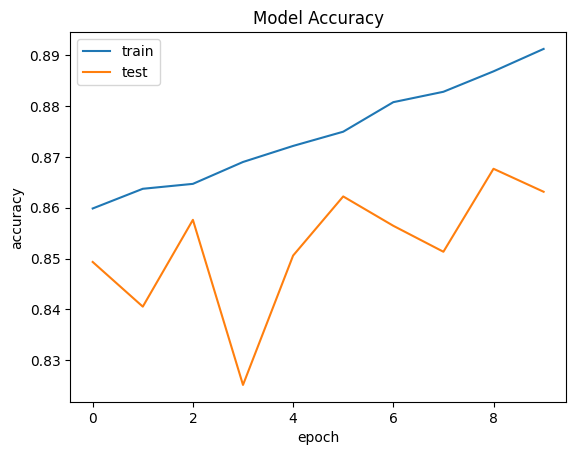

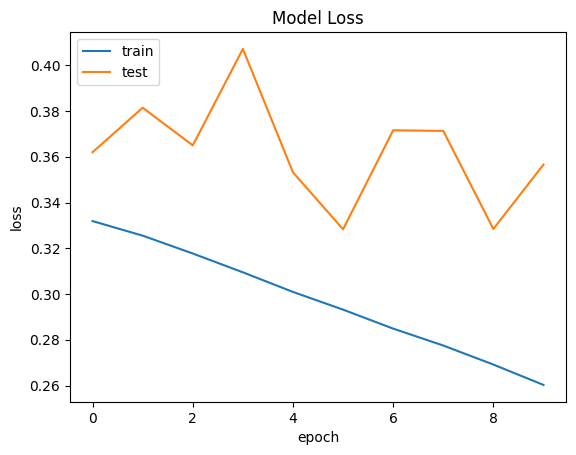

In [ ]:
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Model Accuracy')
plt.xlabel('epoch')
plt.ylabel('accuracy')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model Loss')
plt.xlabel('epoch')
plt.ylabel('loss')
plt.legend(['train', 'test'], loc='upper left')
plt.show()


374/374 [==============================] - 50s 133ms/step


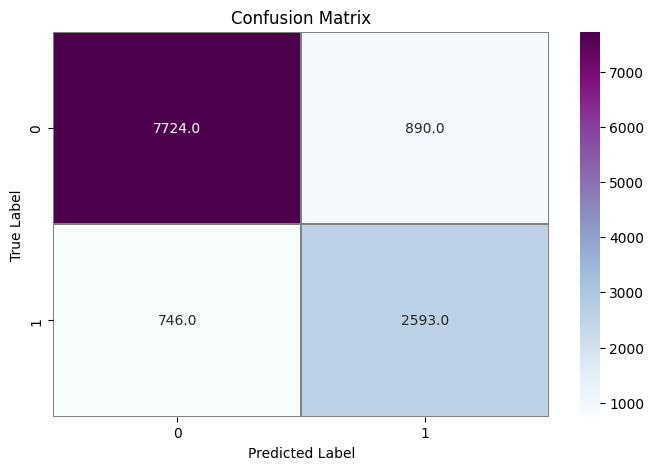

In [ ]:
from sklearn.metrics import accuracy_score
Y_pred = model.predict(X_test)
Y_pred_classes = np.argmax(Y_pred,axis = 1)
Y_true = np.argmax(Y_test,axis = 1)
#accuracy=accuracy_score(y_true=Y_true, y_pred=Y_pred)
#print(accuracy)
confusion_mtx = confusion_matrix(Y_true, Y_pred_classes)
f,ax = plt.subplots(figsize=(8,5))
sns.heatmap(confusion_mtx, annot=True, linewidths=0.01,cmap="BuPu",linecolor="gray", fmt= '.1f',ax=ax)
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.title("Confusion Matrix")
plt.show()


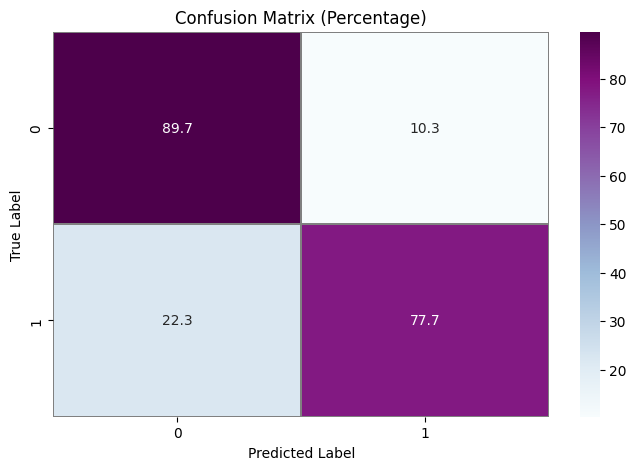

In [ ]:
from sklearn.metrics import accuracy_score, confusion_matrix
#Y_pred = model.predict(X_test)
Y_pred_classes = np.argmax(Y_pred, axis=1)
Y_true = np.argmax(Y_test, axis=1)

confusion_mtx = confusion_matrix(Y_true, Y_pred_classes)

# calculate the percentage
confusion_mtx_percent = confusion_mtx.astype('float') / confusion_mtx.sum(axis=1)[:, np.newaxis] * 100

f, ax = plt.subplots(figsize=(8, 5))
sns.heatmap(confusion_mtx_percent, annot=True, linewidths=0.01, cmap="BuPu", linecolor="gray", fmt='.1f', ax=ax)
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.title("Confusion Matrix (Percentage)")
plt.show()


In [ ]:
model.evaluate(X_test,Y_test)

374/374 [==============================] - 49s 131ms/step - loss: 0.3566 - accuracy: 0.8631


[0.356579065322876, 0.8631305694580078]

# Testing

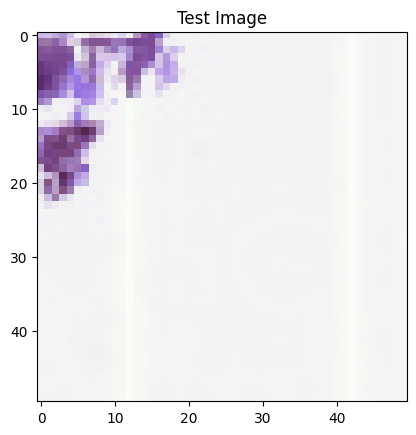

In [ ]:
def img_plot(arr,index=0):
    plt.title('Test Image')
    plt.imshow(arr[index])

index = 1000
img_plot(X_test, index)

In [ ]:
 def img_plot(arr,index=0):
    plt.title('Test Image')
    plt.imshow(arr[index])
index = 4000
input = X_test[index:index+1]
pred = model.predict(input)[0].argmax()
label = Y_test[index].argmax()
print('Predicted Value using  cnn model',pred)
print("True Value",label)


1/1 [==============================] - 0s 70ms/step
Predicted Value using  cnn model 0
True Value 1
